<a href="https://colab.research.google.com/github/Letch49/ML-vvsu-2025/blob/master/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 3: Подбор признаков и валидация моделей

## **Цель занятия:**
Изучить методы поиска значимых признаков в данных. На практике мы проведем анализ целевой переменной **Y**, применим методы для поиска значимых признаков, обучим линейную модель, проанализируем результат и оценим валидность модели.

## **Задание состоит из следующих частей:**
1. Обработка выбросов;
1. Поиск значимых признаков с использованием библиотеки **sklearn**.
2. Обучение логистической регресси модели и оценка ее точности.
6. Кросс-валидация с использованием разных методов (K-fold, ShuffleSplit, test-train-validation)

## 1: Загрузка библиотек и предобратка данных

In [51]:
# !pip install pandas scikit-learn seaborn scipy

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel, f_classif

In [53]:
# Загрузка набора данных
df = pd.read_csv('income.csv')

In [54]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [55]:
df['is_old'] = np.where(df['age'] >= 30, 1, 0).astype(int)
df.is_old = df.is_old.astype('category')
df['education'] = df['education'].astype('category')

In [56]:
Y = df['is_old'] # выбираем целевую переменную (категориальную)
X = df.drop('is_old', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('age', axis=1)

In [57]:
df.drop('age', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   workclass       30725 non-null  object  
 1   education       32561 non-null  category
 2   education-num   32561 non-null  int64   
 3   marital-status  32561 non-null  object  
 4   occupation      30718 non-null  object  
 5   relationship    32561 non-null  object  
 6   race            32561 non-null  object  
 7   sex             32561 non-null  object  
 8   capital-gain    32561 non-null  int64   
 9   capital-loss    32561 non-null  int64   
 10  hours-per-week  32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
 13  is_old          32561 non-null  category
dtypes: category(2), int64(5), object(7)
memory usage: 3.0+ MB


In [58]:
df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K,is_old
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,1
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,1
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,1
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,1
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,0
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,1
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,1
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,0


## 2: масштабирование признаков

In [59]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   workclass       30725 non-null  object  
 1   education       32561 non-null  category
 2   education-num   32561 non-null  int64   
 3   marital-status  32561 non-null  object  
 4   occupation      30718 non-null  object  
 5   relationship    32561 non-null  object  
 6   race            32561 non-null  object  
 7   sex             32561 non-null  object  
 8   capital-gain    32561 non-null  int64   
 9   capital-loss    32561 non-null  int64   
 10  hours-per-week  32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
dtypes: category(1), int64(5), object(7)
memory usage: 3.0+ MB


In [60]:
# Создаем копию данных
X_processed = X.copy()

category_columns: list[str] = X_processed.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X_processed = pd.get_dummies(X_processed, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [61]:
X_processed = X_processed.select_dtypes(include=['int'])
X_processed

,education-num,capital-gain,capital-loss,hours-per-week,income >50K
0,13,2174,0,40,0
1,13,0,0,13,0
2,9,0,0,40,0
3,7,0,0,40,0
4,13,0,0,40,0
...,...,...,...,...,...
32556,12,0,0,38,0
32557,9,0,0,40,1
32558,9,0,0,40,0
32559,9,0,0,20,0


In [62]:
# # Выбираем числовые признаки
numeric_features =['capital-gain', 'capital-loss']

# # Инициализируем scaler
scaler = MinMaxScaler()

# # Применяем нормализацию
X_processed[numeric_features] = scaler.fit_transform(X_processed[numeric_features])


In [63]:
X_processed

,education-num,capital-gain,capital-loss,hours-per-week,income >50K
0,13,0.021740,0.0,40,0
1,13,0.000000,0.0,13,0
2,9,0.000000,0.0,40,0
3,7,0.000000,0.0,40,0
4,13,0.000000,0.0,40,0
...,...,...,...,...,...
32556,12,0.000000,0.0,38,0
32557,9,0.000000,0.0,40,1
32558,9,0.000000,0.0,40,0
32559,9,0.000000,0.0,20,0


## 3: Очистка данных и удаление выбросов

Важным шагом в машинном обучении - является очистка и удаление данных от выбросов.

### Методы обработки выбросов:

1. **Метод на основе медианы и межквартильного размаха (IQR)**:
   - **Как работает**:
     Метод основан на расчете межквартильного размаха (IQR), который вычисляется как разница между третьим (75-й перцентиль) и первым квартилем (25-й перцентиль). Данные считаются выбросами, если они выходят за пределы диапазона \([Q1 - 1.5 * IQR , Q3 + 1.5 * IQR]\).
   - **Зачем это нужно**:
     Выбросы могут серьезно искажать результаты моделей, особенно тех, которые основаны на средних значениях или предполагают нормальное распределение данных.
   - **Когда лучше использовать**:
     - Когда данные содержат **немного выбросов** и имеют **асимметричное распределение**.
     - Метод медианы и IQR более устойчив к выбросам по сравнению с методом, основанным на среднем значении, так как медиана меньше подвержена влиянию экстремальных значений.
     - Хорошо подходит для набора данных, которые не распределены нормально (например, зарплаты или цены на недвижимость).

2. **Метод на основе среднего (Mean)**:
   - **Как работает**:
     Метод использует средние значения и удаляет те признаки или записи, которые значительно отклоняются от среднего. Чаще всего это делается с помощью установления порога (например, данные, которые превышают 2 или 3 средних значения, считаются выбросами).
   - **Зачем это нужно**:
     Выбросы, сильно отличающиеся от средних значений, могут существенно влиять на такие модели, как линейная регрессия, так как среднее значение сильно чувствительно к экстремальным точкам.
   - **Когда лучше использовать**:
     - Когда данные имеют **нормальное распределение** или приближены к нормальному.
     - Подходит, если данные содержат **много выбросов**, и вам нужно жестче ограничить их влияние на модель.

### Как выбрать метод:

- **Если данные асимметричны** или распределены с "хвостами" (например, распределение доходов или цен), лучше использовать **метод на основе медианы и IQR**, так как медиана не чувствительна к выбросам и лучше описывает такие наборы данных.
  
- **Если данные нормально распределены** и важно учитывать всю выборку, даже если есть выбросы, можно использовать **метод на основе среднего**. Этот метод будет точнее отражать центр распределения в симметричных данных и позволит выявить значительные отклонения от него.

Оба метода помогают улучшить производительность моделей машинного обучения, обеспечивая более точное представление данных для анализа и обучения.

### Для начала определеим функцию обучения с оценкой качества (для простоты)

In [64]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate(X, Y):
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y)

    # Инициализация модели
    model = LogisticRegression(max_iter=1000)

    # Обучение модели
    model.fit(X_train, Y_train)

    # Предсказания на обучающей выборке
    Y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, Y_train_pred)

    # Предсказания на тестовой выборке
    Y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Вывод результатов
    print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

    # Классификационный отчет
    print("\nКлассификационный отчет на тестовой выборке:")
    print(classification_report(Y_test, Y_test_pred))

    return model


In [65]:
train_and_evaluate(X_processed.select_dtypes(include=['int']), Y)

Точность на обучающей выборке: 0.7053
Точность на тестовой выборке: 0.7052

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.53      0.09      0.16      1942
           1       0.71      0.97      0.82      4571

    accuracy                           0.71      6513
   macro avg       0.62      0.53      0.49      6513
weighted avg       0.66      0.71      0.62      6513



LogisticRegression(max_iter=1000)

### Метод 1: удаление на основе медианы

In [66]:
# Функция для удаления выбросов на основе межквартильного размаха (1.5 IQR)
def remove_outliers_based_on_iqr(X, y, iqr_multiplier=1.5):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем первый и третий квартили для каждой числовой переменной
    Q1 = X_numeric.quantile(0.25)
    Q3 = X_numeric.quantile(0.75)

    # Вычисляем межквартильный размах (IQR)
    IQR = Q3 - Q1

    # Оставляем только те значения, которые находятся в диапазоне [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    X_filtered = X_numeric[~((X_numeric < (Q1 - iqr_multiplier * IQR)) | (X_numeric > (Q3 + iqr_multiplier * IQR))).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered


In [67]:
X_iqr, y_iqr = remove_outliers_based_on_iqr(X_processed, Y, iqr_multiplier=3)

In [68]:
X_processed.describe()

,education-num,capital-gain,capital-loss,hours-per-week,income >50K
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,10.080679,0.010777,0.020042,40.437456,0.240810
std,2.572720,0.073854,0.092507,12.347429,0.427581
min,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,0.000000,0.000000,40.000000,0.000000
50%,10.000000,0.000000,0.000000,40.000000,0.000000
75%,12.000000,0.000000,0.000000,45.000000,0.000000
max,16.000000,1.000000,1.000000,99.000000,1.000000


In [69]:
X_iqr.describe()

,education-num,capital-gain,capital-loss,hours-per-week,income >50K
count,19456.000000,19456.0,19456.0,19456.000000,19456.0
mean,9.618061,0.0,0.0,40.869346,0.0
std,2.413029,0.0,0.0,6.848434,0.0
min,1.000000,0.0,0.0,25.000000,0.0
25%,9.000000,0.0,0.0,40.000000,0.0
50%,9.000000,0.0,0.0,40.000000,0.0
75%,10.000000,0.0,0.0,40.000000,0.0
max,16.000000,0.0,0.0,60.000000,0.0


In [70]:
train_and_evaluate(X_iqr, y_iqr)

Точность на обучающей выборке: 0.6494
Точность на тестовой выборке: 0.6470

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.56      0.05      0.09      1388
           1       0.65      0.98      0.78      2504

    accuracy                           0.65      3892
   macro avg       0.61      0.51      0.43      3892
weighted avg       0.62      0.65      0.53      3892



LogisticRegression(max_iter=1000)

Об наиболее эффективном методе для отчистки для данного набора данных можно судить по конечным точностям на тестовой выборку и обучающей выборке.

Тут:
Точность на обучающей выборке: 0.6494
Точность на тестовой выборке: 0.6470

Тут точность понизилась - метод не оправдал ожиданий

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

### Метод 2: удаление на основе среднего

In [71]:
# Функция для удаления выбросов на основе среднего значения

def remove_outliers_based_on_mean(X, y, mean_multiplier=2):
    # Убедимся, что работаем только с числовыми данными
    X_numeric = X.select_dtypes(include=['number'])

    # Рассчитываем среднее значение и стандартное отклонение для каждой переменной
    mean_values = X_numeric.mean()
    std_values = X_numeric.std()

    # Устанавливаем верхний и нижний пороги на основе среднего значения и множителя стандартного отклонения
    lower_threshold = mean_values - mean_multiplier * std_values
    upper_threshold = mean_values + mean_multiplier * std_values

    # Фильтруем наблюдения, которые находятся в пределах этих порогов по всем признакам
    X_filtered = X_numeric[~((X_numeric < lower_threshold) | (X_numeric > upper_threshold)).any(axis=1)]

    # Синхронизируем y с отфильтрованными X
    y_filtered = y.loc[X_filtered.index]

    return X_filtered, y_filtered

In [72]:
X_mean, y_mean = remove_outliers_based_on_mean(X_processed.copy(), Y.copy())

In [73]:
X_processed.describe()

,education-num,capital-gain,capital-loss,hours-per-week,income >50K
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,10.080679,0.010777,0.020042,40.437456,0.240810
std,2.572720,0.073854,0.092507,12.347429,0.427581
min,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,0.000000,0.000000,40.000000,0.000000
50%,10.000000,0.000000,0.000000,40.000000,0.000000
75%,12.000000,0.000000,0.000000,45.000000,0.000000
max,16.000000,1.000000,1.000000,99.000000,1.000000


In [74]:
X_mean.describe()

,education-num,capital-gain,capital-loss,hours-per-week,income >50K
count,27383.000000,27383.000000,27383.000000,27383.000000,27383.000000
mean,10.228463,0.005592,0.000157,40.633787,0.227842
std,2.124432,0.022584,0.004926,8.967995,0.419448
min,5.000000,0.000000,0.000000,16.000000,0.000000
25%,9.000000,0.000000,0.000000,40.000000,0.000000
50%,10.000000,0.000000,0.000000,40.000000,0.000000
75%,12.000000,0.000000,0.000000,45.000000,0.000000
max,15.000000,0.158312,0.202020,65.000000,1.000000


In [75]:
train_and_evaluate(X_mean, y_mean)

Точность на обучающей выборке: 0.7099
Точность на тестовой выборке: 0.7102

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.61      0.16      0.25      1683
           1       0.72      0.95      0.82      3794

    accuracy                           0.71      5477
   macro avg       0.66      0.56      0.54      5477
weighted avg       0.69      0.71      0.65      5477



LogisticRegression(max_iter=1000)

Об наиболее эффективном методе для отчистки для данного набора данных можно судить по конечным точностям на тестовой выборку и обучающей выборке.

Тут:
Точность на обучающей выборке: 0.7104
Точность на тестовой выборке: 0.7104

Тут точность повысилась

### ⏰ **Провести анализ выводов, посмотреть как измеились переменные и описать результат**

## 3: Методы отбора признаков

Отбор признаков (feature selection) — важный шаг в машинном обучении, который помогает улучшить качество моделей и ускорить их работу. Цель отбора — убрать лишние или малозначимые признаки, которые не влияют на предсказания модели, либо могут ухудшить её производительность.

Зачем это нужно:
1. **Улучшение производительности модели** — избыточные признаки могут создавать шум и снижать точность.
2. **Повышение интерпретируемости** — меньший набор признаков легче анализировать и объяснять.
3. **Снижение вычислительной сложности** — меньшее количество признаков ускоряет обучение и предсказание.

В sklearn основные методы отбора признаков включают:
1. **Filter методы** — основаны на статистических тестах, например, `SelectKBest` использует критерий, чтобы выбрать признаки с наибольшим вкладом.
2. **Wrapper методы** — оценивают модели на разных подмножествах признаков, например, рекурсивное исключение признаков (`RFE`).
3. **Embedded методы** — выполняют отбор признаков во время обучения модели, например, с помощью L1-регуляризации (Lasso).

### Filter методы

Filter методы основаны на статистических свойствах данных и выбирают признаки, не учитывая алгоритм машинного обучения. Они работают как предварительный шаг перед обучением модели и быстро отбирают наиболее информативные признаки.

Преимущества:

- Быстро выполняются.
- Не зависят от модели.
- Уменьшают размерность данных до обучения.

Недостатки:

- Не учитывают взаимодействие между признаками.
- Могут упускать важные комбинации признаков.

In [76]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif


In [77]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_regression, k=5)
X_kbest = selector.fit_transform(X_processed.select_dtypes(include=['int']), Y)

/home/ilua/Desktop/staff/web-python/venv/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=5 is greater than n_features=3. All the features will be returned.
  warnings.warn(


In [78]:
selector.scores_

array([ 322.52450081, 1386.68034263, 2920.94856062])

In [79]:
X_processed.columns

Index(['education-num', 'capital-gain', 'capital-loss', 'hours-per-week',
       'income >50K'],
      dtype='object')

In [80]:
X_processed

,education-num,capital-gain,capital-loss,hours-per-week,income >50K
0,13,0.021740,0.0,40,0
1,13,0.000000,0.0,13,0
2,9,0.000000,0.0,40,0
3,7,0.000000,0.0,40,0
4,13,0.000000,0.0,40,0
...,...,...,...,...,...
32556,12,0.000000,0.0,38,0
32557,9,0.000000,0.0,40,1
32558,9,0.000000,0.0,40,0
32559,9,0.000000,0.0,20,0


⏰ Изучите 1 из методов и используйте его как score_func (Важно учитывать, что не все методы могут подходить под тип признака, например chi2 подходит только для категориальных)

```**P.S. методы работают по разному для дискретных и непрерывных значений. Методы необходимо использовать для своих типов переменных!**```

[link](https://scikit-learn.org/stable/modules/feature_selection.html)

**f_classif**: ANOVA F-value between label/feature for classification tasks.

**mutual_info_classif**: Mutual information for a discrete target.

**chi2**: Chi-squared stats of non-negative features for classification tasks.

**f_regression**: F-value between label/feature for regression tasks.

**mutual_info_regression**: Mutual information for a continuous target.

**SelectPercentile**: Select features based on percentile of the highest scores.

**SelectFpr**: Select features based on a false positive rate test.

**SelectFdr**: Select features based on an estimated false discovery rate.

**SelectFwe**: Select features based on family-wise error rate.

**GenericUnivariateSelect**: Univariate feature selector with configurable mode.

In [81]:
# Применяем SelectKBest для выбора 5 лучших признаков
selector = SelectKBest(score_func=f_classif, k=2)
X_kbest = selector.fit_transform(X_processed, Y)

Univariate feature selection

In [82]:
selector.get_support(indices=True)

array([3, 4])

In [83]:
# Получаем список отобранных признаков
selected_features = X_processed.columns[selector.get_support(indices=True)]
print("Отобранные признаки:", selected_features)

Отобранные признаки: Index(['hours-per-week', 'income >50K'], dtype='object')


In [84]:
# Преобразуем X_kbest в DataFrame
X_kbest_df = pd.DataFrame(X_kbest, columns=selected_features)

# Обучаем и оцениваем модель
train_and_evaluate(X_kbest_df, Y)

Точность на обучающей выборке: 0.7045
Точность на тестовой выборке: 0.7044

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.53      0.08      0.14      1942
           1       0.71      0.97      0.82      4571

    accuracy                           0.70      6513
   macro avg       0.62      0.53      0.48      6513
weighted avg       0.66      0.70      0.62      6513



LogisticRegression(max_iter=1000)

Метод не оправдал ожиданий, точность понизилась

### Wrapper методы

Wrapper методы оценивают различные комбинации признаков, обучая модель на каждом подмножестве, и выбирают набор признаков, который дает наилучшее качество модели. Они учитывают взаимодействия между признаками, но могут быть вычислительно затратными.

Преимущества:

- Учитывают взаимодействия между признаками.
- Могут улучшить производительность модели.

Недостатки:

- Высокая вычислительная сложность.
- Длительное время выполнения на больших наборах данных.

In [85]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Инициализируем модель логистической регрессии
base_model = LogisticRegression(max_iter=1000)

# Инициализируем RFE для выбора 5 лучших признаков
rfe = RFE(estimator=base_model, n_features_to_select=2)
rfe.fit(X_processed.select_dtypes(include=['int']), Y)

# Получаем список отобранных признаков
selected_features = X_processed.select_dtypes(include=['int']).columns[rfe.support_]
print("Отобранные признаки:", selected_features)


Отобранные признаки: Index(['hours-per-week', 'income >50K'], dtype='object')


In [86]:
# Отбираем признаки
X_rfe = X_processed[selected_features]

# Обучаем и оцениваем модель
model = train_and_evaluate(X_rfe, Y)


Точность на обучающей выборке: 0.7045
Точность на тестовой выборке: 0.7044

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.53      0.08      0.14      1942
           1       0.71      0.97      0.82      4571

    accuracy                           0.70      6513
   macro avg       0.62      0.53      0.48      6513
weighted avg       0.66      0.70      0.62      6513



### Embedded методы

Преимущества:

Учитывают взаимодействия между признаками.
- Менее вычислительно затратны, чем Wrapper методы.
- Интегрированы в процесс обучения.
Недостатки:

- Зависимы от выбранной модели.
- Могут не отбирать признаки, важные для других моделей.

Коэффициенты модели без регуляризации: [[-0.00825641  0.0284161   1.98971495]]
Коэффициенты модели с регуляризацией: [[-0.0094814   0.02824863  1.99448856]]
Отобранные признаки: Index(['education-num', 'hours-per-week', 'income >50K'], dtype='object')
Коэффициенты модели после отбора признаков: [[-0.00994185  0.02815662  1.99548534]]


/home/ilua/Desktop/staff/web-python/venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


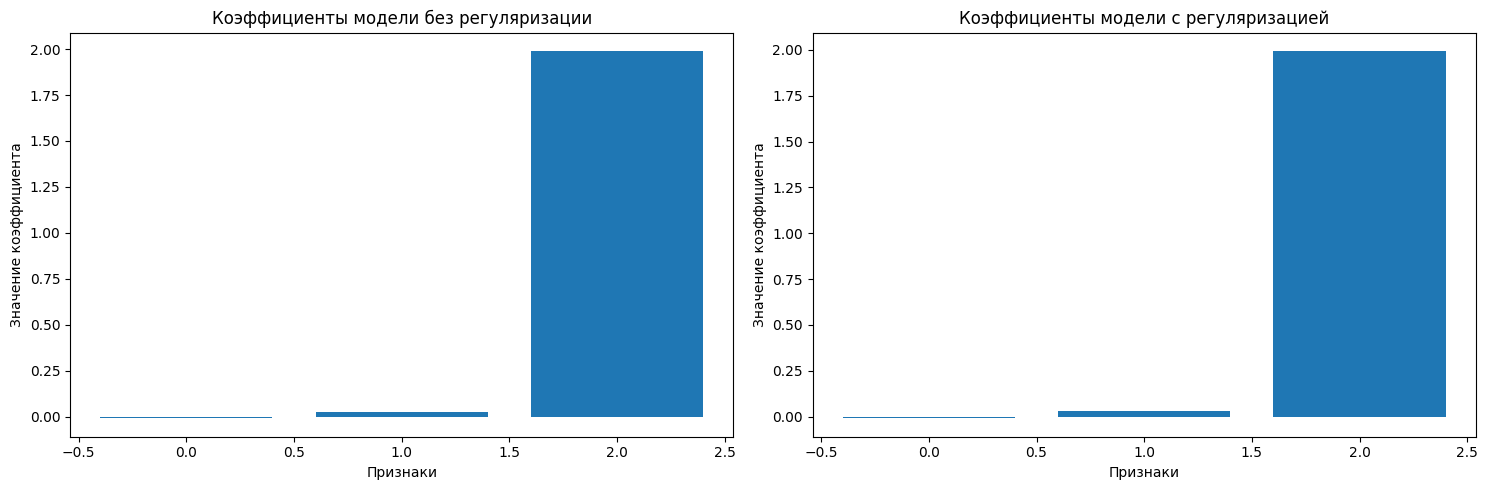

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt

# Обучаем модель без регуляризации
model_no_penalty = LogisticRegression(solver='lbfgs', max_iter=1000)
model_no_penalty.fit(X_processed.select_dtypes(include=['int']), Y)

# Выводим коэффициенты модели без регуляризации
coefficients_no_penalty = model_no_penalty.coef_
print("Коэффициенты модели без регуляризации:", coefficients_no_penalty)

# Инициализируем модель с L1-регуляризацией
model_with_penalty = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

# Обучаем модель с регуляризацией
model_with_penalty.fit(X_processed.select_dtypes(include=['int']), Y)

# Выводим коэффициенты модели с регуляризацией
coefficients_with_penalty = model_with_penalty.coef_
print("Коэффициенты модели с регуляризацией:", coefficients_with_penalty)

# Используем SelectFromModel для отбора признаков
selector = SelectFromModel(model_with_penalty, prefit=True)
X_embedded = selector.transform(X_processed.select_dtypes(include=['int']))

# Получаем список отобранных признаков
selected_features = X_processed.select_dtypes(include=['int']).columns[selector.get_support()]
print("Отобранные признаки:", selected_features)

# Обучаем модель на отобранных признаках
model_embedded = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_embedded.fit(X_processed.select_dtypes(include=['int']), Y)

# Выводим коэффициенты модели после отбора признаков
coefficients_embedded = model_embedded.coef_
print("Коэффициенты модели после отбора признаков:", coefficients_embedded)

# Визуализация коэффициентов моделей
plt.figure(figsize=(15, 5))

# Коэффициенты модели без регуляризации
plt.subplot(1, 2, 1)
plt.bar(range(len(coefficients_no_penalty[0])), coefficients_no_penalty[0])
plt.title("Коэффициенты модели без регуляризации")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

# Коэффициенты модели с регуляризацией
plt.subplot(1, 2, 2)
plt.bar(range(len(coefficients_with_penalty[0])), coefficients_with_penalty[0])
plt.title("Коэффициенты модели с регуляризацией")
plt.xlabel("Признаки")
plt.ylabel("Значение коэффициента")

plt.tight_layout()
plt.show()

In [88]:
# Преобразуем X_embedded в DataFrame
X_embedded_df = pd.DataFrame(X_embedded, columns=selected_features)

# Обучаем и оцениваем модель
model = train_and_evaluate(X_embedded_df, Y)


Точность на обучающей выборке: 0.7053
Точность на тестовой выборке: 0.7052

Классификационный отчет на тестовой выборке:
              precision    recall  f1-score   support

           0       0.53      0.09      0.16      1942
           1       0.71      0.97      0.82      4571

    accuracy                           0.71      6513
   macro avg       0.62      0.53      0.49      6513
weighted avg       0.66      0.71      0.62      6513



### ⏰ **Проэксперементировать с разным количеством k, найти лучшую модель, объяснить результат**

### ⏰ **Изучить метод отбора ```SequentialFeatureSelector```, описать способ работы, сравнить результат с прошлыми методами и объяснить полученный результат**

## Логистическая регрессия

**Логистическая регрессия** — это модель для задач бинарной классификации, которая предсказывает вероятность того, что наблюдение принадлежит к одному из двух классов (например, 0 или 1). Модель основана на линейной регрессии, но использует **сигмоидную функцию активации** для приведения предсказаний в диапазон от 0 до 1. Логистическая регрессия идеально подходит для задач, где нужно классифицировать данные на два класса.


#### Принцип работы логистической регрессии:
1. Сначала вычисляется линейная комбинация признаков с весами:  
y = b + w1 * x1 + w2 * x2 + w(n) * x(n), где

x - переменные

w - веса (коэфициенты регресси)

b - смещение

Затем результат линейной комбинации передается в сигмоидную функцию активации, которая преобразует результат в значение от 0 до 1.

### Функция активации (Сигмоида)
**Сигмоидная функция** в логистической регрессии используется для преобразования линейной комбинации признаков в вероятность, что наблюдение относится к классу 1. Формула сигмоиды:

sigmoida = 1 / (1 + e^-y)

Она всегда возвращает значение в диапазоне от 0 до 1, что удобно для интерпретации как вероятность принадлежности к классу 1.

Принцип работы:
1. Инициализация весов: Изначально все веса устанавливаются в нули.

2. Градиентный спуск: На каждой итерации:
- Вычисляется линейная комбинация признаков.
- Применяется сигмоидная функция для предсказания вероятностей.
- Градиенты вычисляются для обновления весов и смещения, минимизируя ошибку.

Предсказание: Для новых данных модель возвращает вероятность, которая затем конвертируется в классы 0 или 1.

In [89]:
import numpy as np

# Сигмоидная функция
def sigmoid(z):
    # Убедимся, что z это numpy массив
    return 1 / (1 + np.exp(-z))

# Простая реализация логистической регрессии
class OwnLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations

    # Метод для обучения модели
    def fit(self, X, y):
        # Инициализация весов
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        # Градиентный спуск
        for idx_,_ in enumerate(range(self.iterations)):
            # Линейная комбинация
            linear_model = np.dot(X, self.weights) + self.bias
            # Применяем сигмоиду для предсказания
            y_pred = sigmoid(linear_model)

            # Вычисляем градиенты
            dw = (1 / len(X)) * np.dot(X.T, (y_pred - y))
            db = (1 / len(X)) * np.sum(y_pred - y)

            # Обновляем веса и смещение
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Метод для предсказания
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        print("regression",linear_model)
        y_pred = sigmoid(linear_model)
        print("sigmoid",y_pred)
        # Возвращаем метки классов (0 или 1)
        return [1 if i > 0.5 else 0 for i in y_pred]


In [90]:
# Пример использования
X = np.array([[0.1, 1.2], [1.1, 2.2], [2.1, 1.9], [1.0, 1.0]])
y = np.array([0, 1, 1, 0])

model = OwnLogisticRegression(learning_rate=0.1, iterations=1000)
model.fit(X, y)
predictions = model.predict(X)



regression [-2.48902698  1.89302513  3.0459193  -1.27754449]
sigmoid [0.07663102 0.86910007 0.95460602 0.2179685 ]


### ⏰ Вопрос о принципе работы регресси будет в первом теоретическом модуле, важно понимание как оно работает

## 5: Кросс-валидация

**Кросс-валидация** — это метод оценки качества моделей машинного обучения, который помогает избежать переобучения и получить более надежную оценку. Она заключается в разделении данных на несколько частей и обучении модели на различных подмножествах данных, чтобы проверить ее способность обобщать на новых данных.

Основные цели кросс-валидации:

Проверить, насколько хорошо модель будет работать на новых данных.
Определить, есть ли у модели проблемы с переобучением (overfitting) или недообучением (underfitting).
Помочь выбрать наилучшую модель или гиперпараметры.

#### Виды кросс-валидации
1. K-fold Cross-Validation:

Данные делятся на K равных частей (folds). Модель обучается на K-1 частях и тестируется на оставшейся части. Процесс повторяется K раз, и результат — среднее качество по всем K итерациям.
Этот метод позволяет эффективно использовать все данные как для обучения, так и для тестирования.

2. ShuffleSplit:

Этот метод несколько раз случайно перемешивает данные и делит их на тренировочные и тестовые выборки. В отличие от K-fold, здесь нет необходимости в разделении на фиксированное количество частей.
Хорошо работает на небольших выборках данных и для оценки стабильности модели.

3. Train-Test-Validation Split:

Данные делятся на три части: тренировочные данные для обучения модели, тестовые данные для первичной оценки и валидационные данные для окончательной оценки.
Полезен для задач, где требуется как тестирование, так и финальная проверка на отложенных данных.

In [91]:
# Импорт необходимых библиотек
import numpy as np
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, cross_val_score

In [92]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    # Реализация K-Fold вручную
    for train_index, test_index in kf.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому фолду
    print(n_splits)
    print(f"K-Fold Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому фолду: {accuracies}")

# Пример использования:

for i in range(2,10):
    k_fold_cross_validation(X = X_processed.to_numpy(), y = Y.to_numpy(),n_splits=i)


2
K-Fold Cross-Validation - Средняя точность: 0.7086082879200624
Точности по каждому фолду: [0.7141453227688717, 0.7030712530712531]
3
K-Fold Cross-Validation - Средняя точность: 0.7081476100539694
Точности по каждому фолду: [0.7111663902708679, 0.7107978625391561, 0.7024785773518842]
4
K-Fold Cross-Validation - Средняя точность: 0.7095606059600041
Точности по каждому фолду: [0.7066699422675347, 0.7185503685503686, 0.7008599508599509, 0.7121621621621622]
5
K-Fold Cross-Validation - Средняя точность: 0.7083627962370478
Точности по каждому фолду: [0.7073545217257792, 0.7166769041769042, 0.7151412776412777, 0.691953316953317, 0.7106879606879607]
6
K-Fold Cross-Validation - Средняя точность: 0.7090692200263828
Точности по каждому фолду: [0.7066519255573982, 0.7138382163257785, 0.7154965911184816, 0.7086788280818132, 0.6978072599963148, 0.7119424990785109]
7
K-Fold Cross-Validation - Средняя точность: 0.7090687115825249
Точности по каждому фолду: [0.7141014617368874, 0.7078675838349097, 0.7

Нет значительного выйгрыша в точности, так как повышинная точность в одних фолдах компенсируется пониженной в других

### ⏰ **Используем результат отбора признаков (выбираем по наилучшей точности), делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [93]:
# ShuffleSplit Cross-Validation
def shuffle_split_cross_validation(X, y, n_splits=15, test_size=0.4):
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size)
    accuracies = []

    # Реализация ShuffleSplit вручную
    for train_index, test_index in ss.split(X):
        model = LogisticRegression(max_iter=1000)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение модели на тренировочной выборке
        model.fit(X_train, y_train)

        # Предсказания на тестовой выборке
        y_pred = model.predict(X_test)

        # Оценка точности
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    # Выводим среднюю точность и точности по каждому разделению
    print(n_splits)
    print(f"ShuffleSplit Cross-Validation - Средняя точность: {np.mean(accuracies)}")
    print(f"Точности по каждому разделению: {accuracies}")

for i in range(2,10):
    shuffle_split_cross_validation(X_processed.to_numpy(), Y.to_numpy(), n_splits=i)


2
ShuffleSplit Cross-Validation - Средняя точность: 0.7089059500959694
Точности по каждому разделению: [0.7097120921305182, 0.7080998080614204]
3
ShuffleSplit Cross-Validation - Средняя точность: 0.7109404990403071
Точности по каждому разделению: [0.7080998080614204, 0.7147792706333973, 0.7099424184261036]
4
ShuffleSplit Cross-Validation - Средняя точность: 0.7094241842610365
Точности по каждому разделению: [0.717236084452975, 0.7034932821497121, 0.7112476007677543, 0.7057197696737044]
5
ShuffleSplit Cross-Validation - Средняя точность: 0.7078387715930903
Точности по каждому разделению: [0.7104798464491363, 0.7072552783109405, 0.6995777351247601, 0.7139347408829174, 0.7079462571976968]
6
ShuffleSplit Cross-Validation - Средняя точность: 0.7123224568138196
Точности по каждому разделению: [0.7159309021113244, 0.7140882917466411, 0.7112476007677543, 0.7113243761996161, 0.7087140115163147, 0.7126295585412667]
7
ShuffleSplit Cross-Validation - Средняя точность: 0.7115985741705512
Точности п

Каждый раз получаются случайные результаты точности (из-за перемешивания данных), можно ожидать небольшой прирост или понижение точности на отдельных итерациях

### ⏰ **Используем результат отсечения выбросов, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

In [94]:
# Train-Test-Validation Split
def train_test_validation_split(X, y):
    model = LogisticRegression(max_iter=1000)
    # Разделяем данные на тренировочные и оставшиеся (валидация + тест)
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

    # Разделяем оставшиеся данные на валидационные и тестовые
    X_train_train, X_test, y_train_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Обучаем модель на тренировочных данных
    model.fit(X_train_train, y_train_train)

    # Оцениваем на валидационных данных
    y_valid_pred = model.predict(X_validation)
    validation_accuracy = accuracy_score(y_validation, y_valid_pred)
    print(f"Точность на валидационных данных: {validation_accuracy}")

    # Оцениваем на тестовых данных
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Точность на тестовых данных: {test_accuracy}")

# Пример использования:
train_test_validation_split(X_processed.to_numpy(), Y.to_numpy())


Точность на валидационных данных: 0.7093505297098112
Точность на тестовых данных: 0.7072936660268714


Результат примерно такой же как и в предыдущих методах. Нет перебора, так как данные делятся на три части

### ⏰ **Используем результат отсечения выбросов или лучший отбор признаков, делаем кросс валидацию и объясняем результат + перебираем параметры n_splits**

### Когда использовать каждый метод:
- K-fold Cross-Validation: Отлично подходит для более точной оценки модели, особенно на небольших наборах данных. Используется, когда нужно получить стабильную оценку по всем данным.

- ShuffleSplit Cross-Validation: Хорошо работает на небольших выборках, где нужно много раз случайно перемешивать и проверять модель. Это может помочь увидеть, как модель работает на различных случайных подвыборках данных.

- Train-Test-Validation Split: Используется, когда нужно четко разделить данные для обучения, подбора параметров и финальной оценки. Подходит для больших наборов данных, где важно иметь отложенную тестовую выборку для окончательной проверки.

### ⏰ **Объяснить, какой из методов подходит для вашего датасета**

Выбор метода зависит больше не от датасета, а от задачи которую мы ставим при работе с данными